# Практическая работа №1
## Предварительная обработка данных
Выполнил: Терентьев Никита Александрович КИ21-16/1б
Вариант: 21
## Цель работы
Знакомство с основными задачами предварительной обработки исходных данных, изучение основных методов предварительной обработки данных, формирование навыков выполнения предварительной обработки исходных данных с помощью языка программирования Python.
## Задачи
Выполнение практической работы предполагает решение следующих задач:
1. Визуальный анализ исходных данных
2. Поиск аномальных значений
3. Поиск и восстановление отсутствующих значений
4. Преобразование данных
## Ход работы
Был произведён импорт необходимых библиотек.

In [1]:
import pandas as pd
import numpy as np
import sklearn.impute

from scipy.stats import sigmaclip
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from functions import build_bar_and_pie_chart, build_histogram_density_diagram, build_histogram

Произведено чтение файла и взятие нужных колонок из таблицы в соответствии с вариантом.

In [2]:
dataframe = pd.read_excel(r"C:\Users\nikit\Desktop\Программирование\4 семестр\data_analysis_methods\1 lab\data\first_practice_dataframe.xlsx")
# Названия колонок датафрейма храним в константах
qualitative_variables = ["cat1_gender", "cat3_education"]
quantitative_variables = ["num1_22", "num2_22", "num3_22"]
dataframe = dataframe[[*qualitative_variables, *quantitative_variables]]
initial_dataframe = dataframe.copy()
dataframe

,cat1_gender,cat3_education,num1_22,num2_22,num3_22
0,male,high school,311.628509,664.606363,648.5319
1,male,phd,88.551646,1001.232482,665.864398
2,male,School SAT,314.105165,806.071418,667.958668
3,NaN,BSc,-168.550590,987.065373,651.231183
4,male,phd,294.298042,1216.844021,645.612568
...,...,...,...,...,...
995,male,phd,-34.721255,NaN,619.945966
996,male,phd,-55.516395,858.140616,637.922461
997,male,phd,-43.164240,717.465601,675.80899
998,NaN,phd,-220.999640,1001.632875,NaN


Выведем типы данных в нашем датафрейме.

In [3]:
dataframe.dtypes

cat1_gender        object
cat3_education     object
num1_22           float64
num2_22           float64
num3_22            object
dtype: object

### 1. Визуальный анализ данных
Были построены графики для визуального представления каждого столбца(признака) в исходном наборе данных.
Все функции для построения графиков были вынесены в отдельный файл functions.py

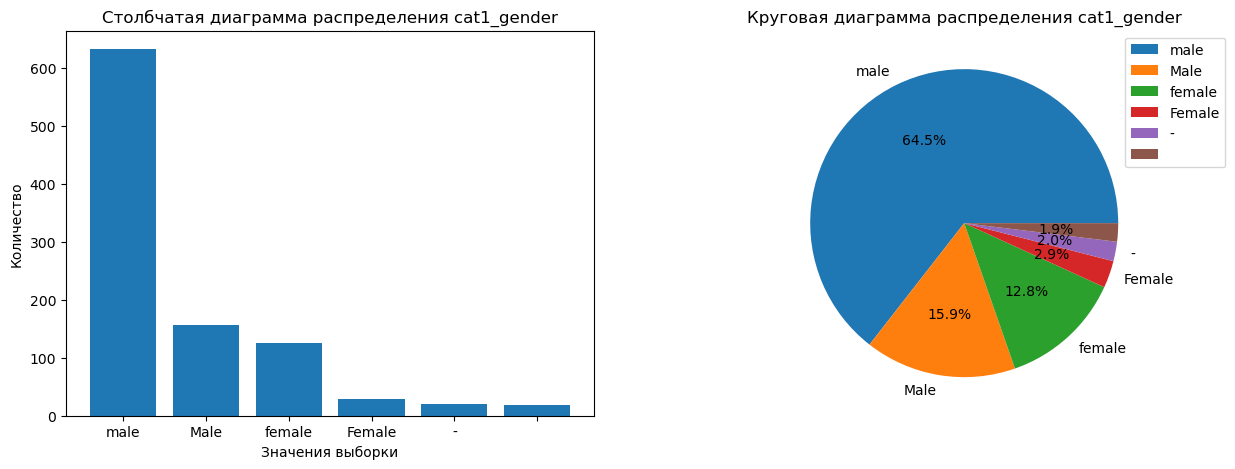

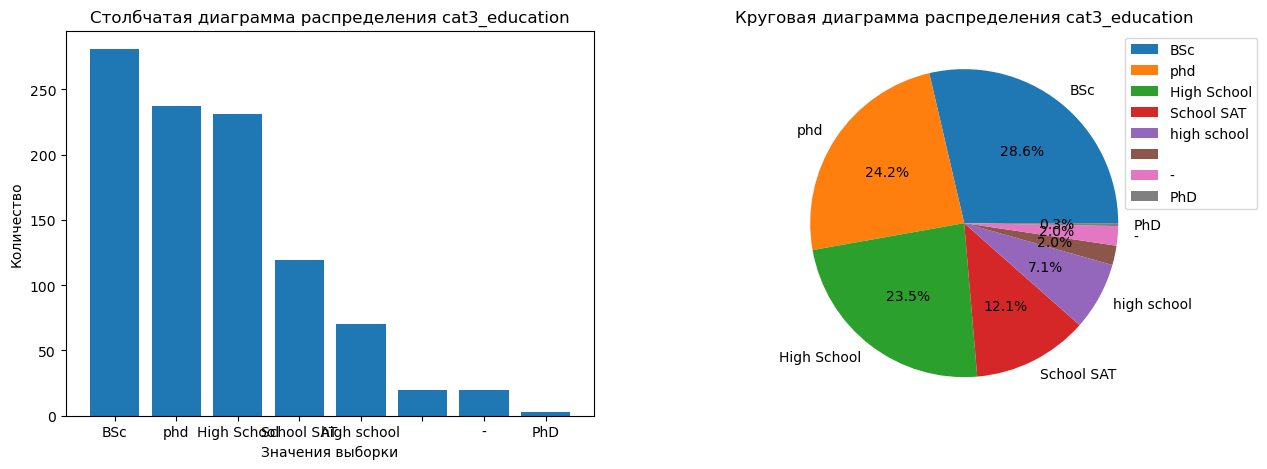

In [4]:
for column in qualitative_variables:
    build_bar_and_pie_chart(dataframe[column], column)

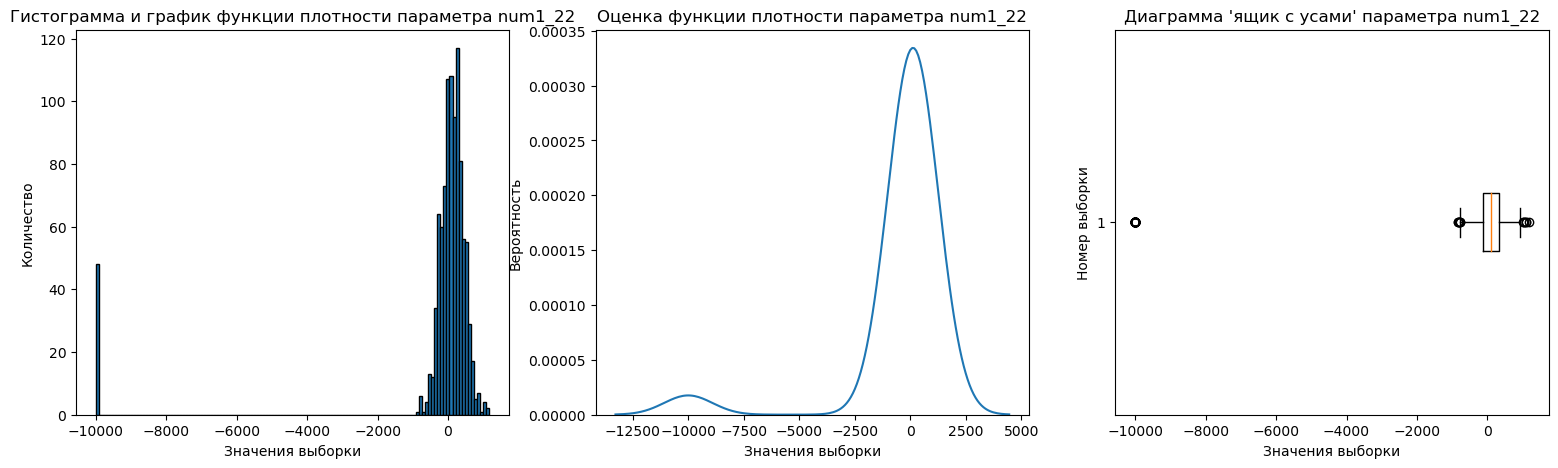

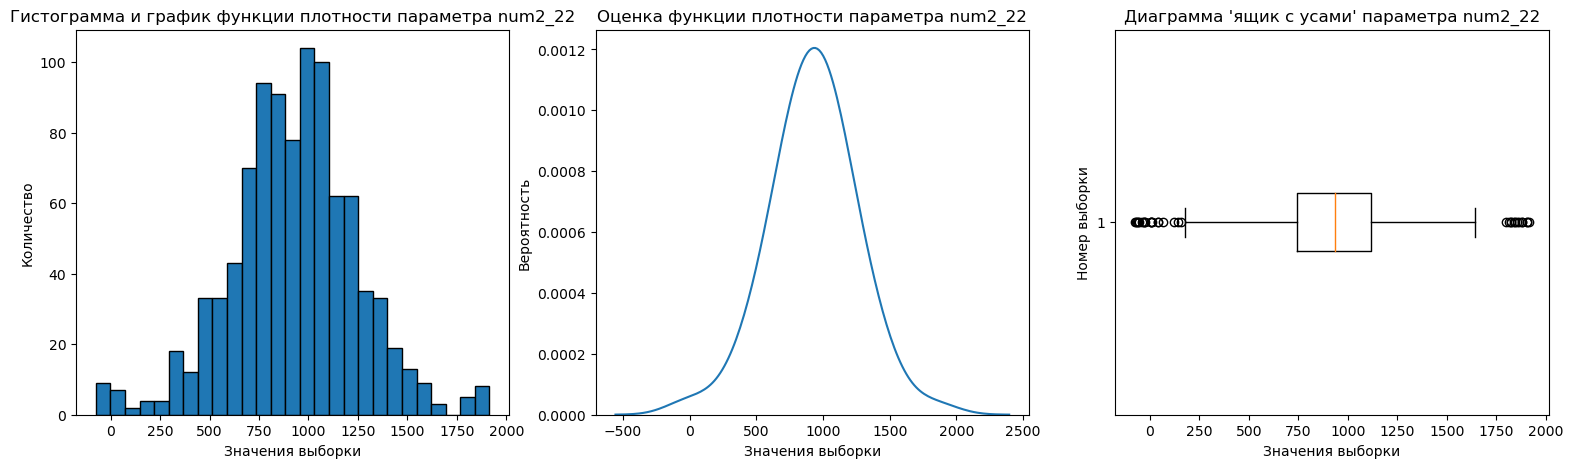

График признака num3_22 не может быть построен, так как столбец содержит не только числовые значения.


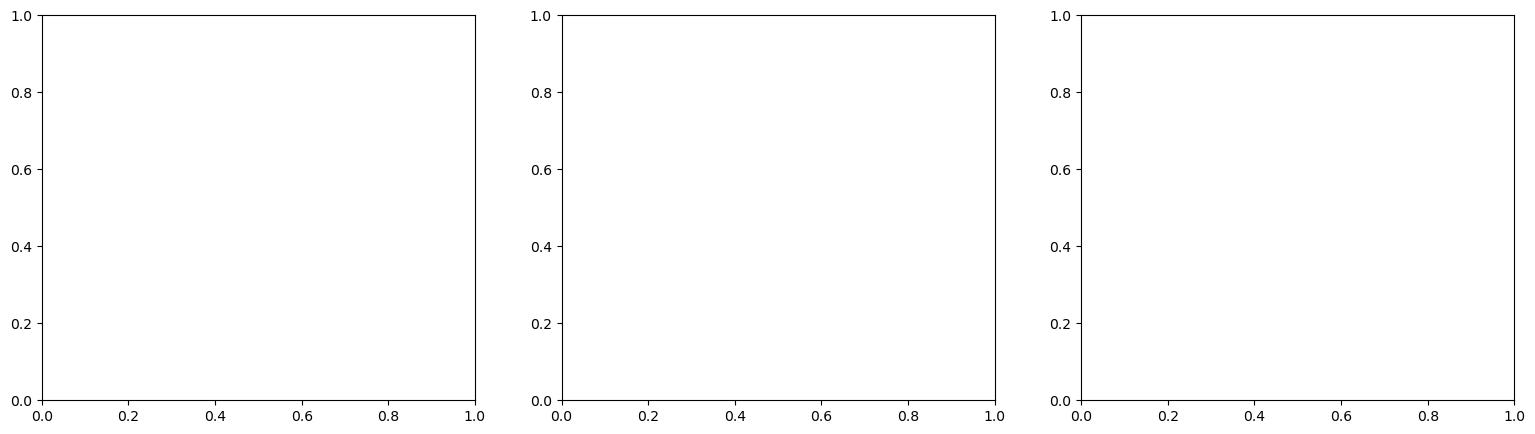

In [5]:
for column in quantitative_variables:
    try:
        build_histogram_density_diagram(dataframe[column],column)
    except TypeError:
        print(f"График признака {column} не может быть построен, так как столбец содержит не только числовые значения.")

### 2. Проверка правдоподобности исходных данных
Проанализировав полученные графики, можно сделать вывод, что некоторые значения из таблицы являются некорректными (например, пропуски значений).

#### Приведение значений качественных признаков
Приведём значения качественных признаков к нужному формату (всем пустым значениям был присвоен тип None, признаки, отличающиеся типом написания, были приведены к одному виду). Также первая и вторая колонка были приведены к категориальному типу.

In [6]:
for column in qualitative_variables:
    dataframe[column].replace({" ": None, "-": None, np.nan: None}, inplace=True)
    dataframe[column] = dataframe[column].apply(lambda x: x.capitalize() if isinstance(x, str) else x)
    dataframe[column] = dataframe[column].astype("category")

#### Приведение значений количественных признаков

In [7]:
for column in quantitative_variables:
    # Если errors='coerce', то недопустимый синтаксический анализ будет установлен как NaN.
    dataframe[column] = pd.to_numeric(dataframe[column], errors='coerce')

In [8]:
dataframe.dtypes

cat1_gender       category
cat3_education    category
num1_22            float64
num2_22            float64
num3_22            float64
dtype: object

Выведем ещё раз все графики.

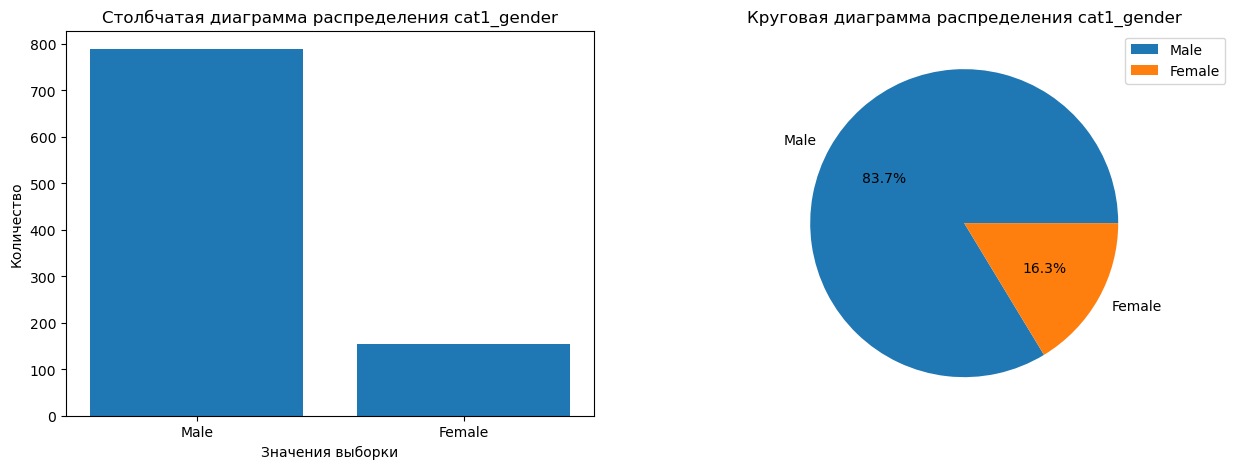

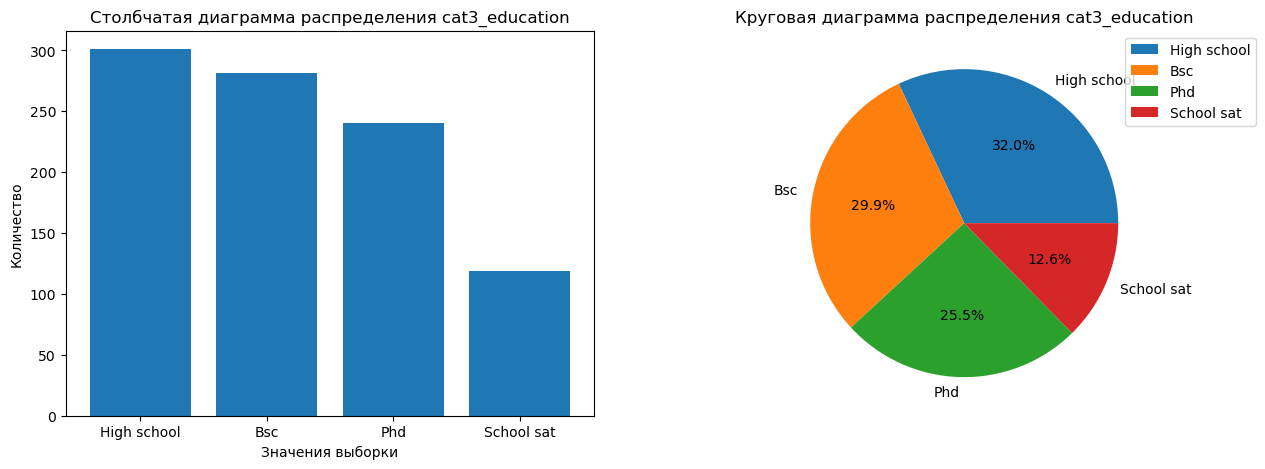

In [10]:
for column in qualitative_variables:
    build_bar_and_pie_chart(dataframe[column], column)

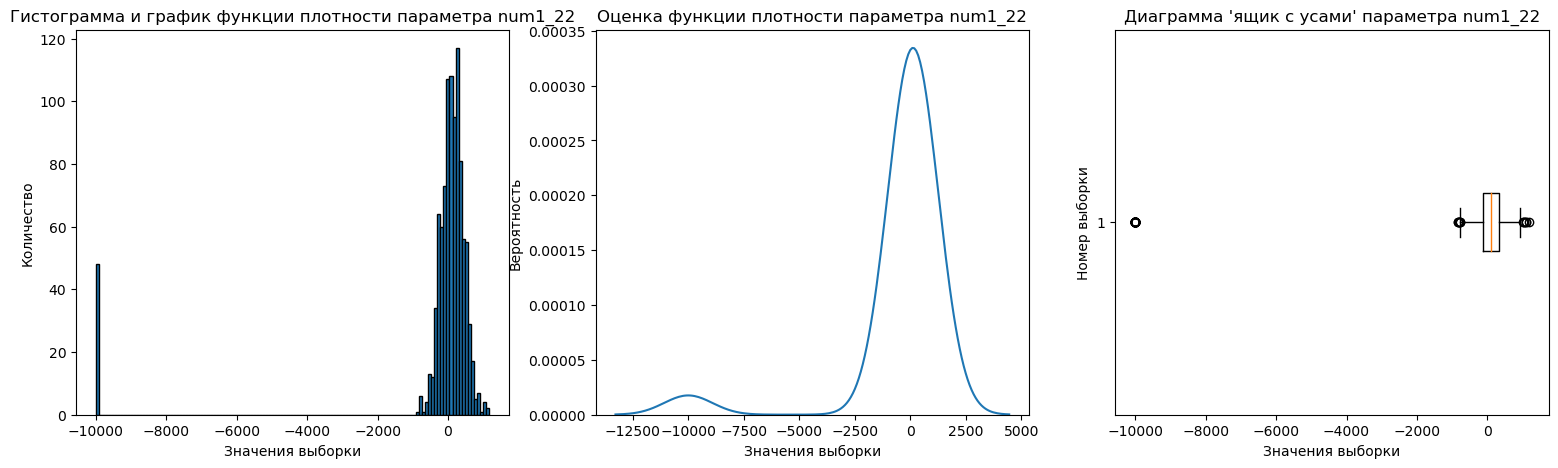

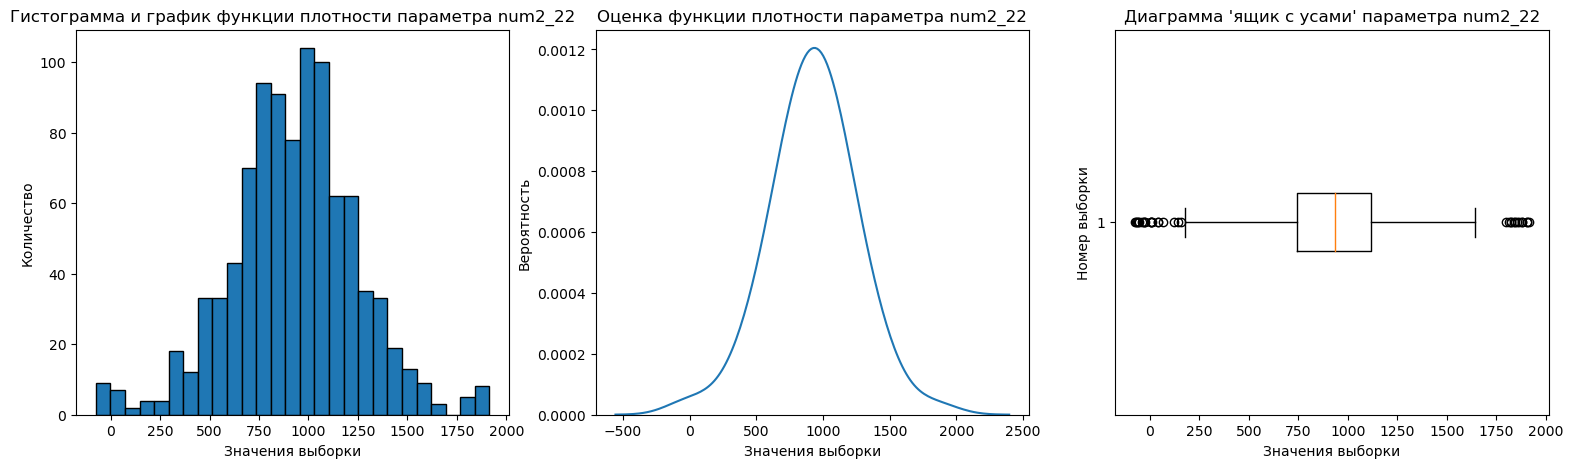

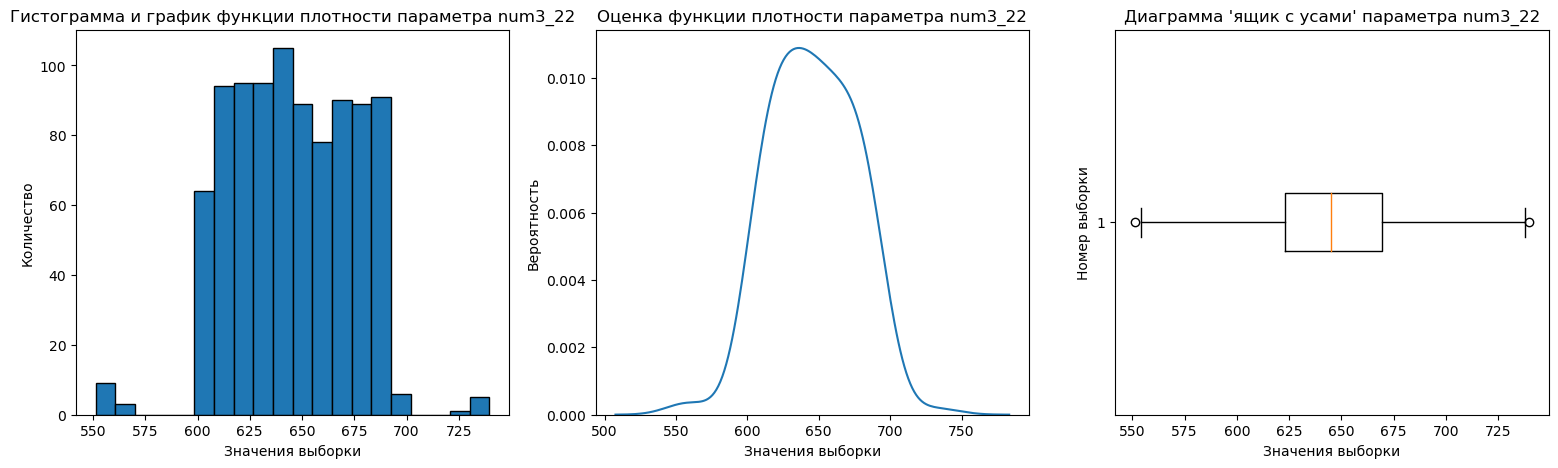

In [11]:
for column in quantitative_variables:
    try:
        build_histogram_density_diagram(dataframe[column],column)
    except TypeError:
        print(f"График признака {column} не может быть построен, так как столбец содержит не только числовые значения.")

Все данные были приведены к нужному формату. Все качественные признаки имеют тип category, все количественные - float64.

### 4. Поиск и восстановление пропущенных значений
Пропуски значений будут заменены значениями, полученными с помощью метода "k-ближайших соседей".
Для начала были выведены значения и их количество в столбце.

In [ ]:
dataframe[GENDER].value_counts()

Значения первого признака были преобразованы к числовым кодам.

In [ ]:
label_encoder = LabelEncoder()
dataframe[GENDER] = label_encoder.fit_transform(dataframe[GENDER])
dataframe[GENDER].value_counts()

Вывод функции value_counts позволяет увидеть, что значениям типа None был присвоен числовой код 2. Преобразуем их обратно к типу None и заменим значениями, полученными методом "k-ближайших соседей".

In [ ]:
dataframe[GENDER].replace(to_replace=2, value=None, inplace=True)
dataframe_copy = dataframe.copy()
knn_inputer = sklearn.impute.KNNImputer()
inputed_dataframe = knn_inputer.fit_transform(dataframe_copy[[GENDER, NUM1, NUM2, NUM3]])
dataframe[GENDER] = inputed_dataframe[:, 0]
dataframe[GENDER] = dataframe[GENDER].apply(
    lambda x: round(x) # Округляем значения до целого числа
)
print(dataframe[GENDER].value_counts())
dataframe[GENDER]

In [ ]:
dataframe[GENDER] = label_encoder.inverse_transform(dataframe[GENDER])
dataframe[GENDER].value_counts()

Пропуски значений второго признака были заменены самым популярным значением.

In [ ]:
print(dataframe[EDUCATION].value_counts())

In [ ]:
dataframe[EDUCATION] = dataframe[EDUCATION].fillna("High School")

Пропуски значений четвёртого признака были заменены медианой.

In [ ]:
median = dataframe[NUM2].median()
dataframe[NUM2] = dataframe[NUM2].fillna(median)

Пропуски значений пятого признака были заменены значениями, полученными методом "k-ближайших соседей".

In [ ]:
# Делаем копию датафрейма, чтобы сохранить значение колонок
frame_copy = dataframe.copy()
inputed_dataframe = knn_inputer.fit_transform(frame_copy[[NUM1, NUM2, NUM3]])
dataframe[NUM3] = inputed_dataframe[:, 2]

Все значения были восстановлены.

In [ ]:
dataframe.count()

### 3. Поиск аномальных значений
Было произведено копирование датафрейма, чтобы можно было в дальнейшем сравнить два метода.

In [ ]:
dataframe_copy = dataframe.copy()
dataframe_sigma = dataframe.copy()
dataframe_quantile = dataframe.copy()

#### Метод сигм
Были найдены значения для 1 числового параметра, резко отличающиеся от других (выбросы). Строки с найденными выбросами были удалены из датафрейма.

In [ ]:
_, low, upp = sigmaclip(dataframe_sigma[NUM1], 3, 3)
dropped_values = dataframe_sigma[NUM1][(dataframe_sigma[NUM1] < low) | (dataframe_sigma[NUM1] > upp)]
dataframe_sigma = dataframe_sigma.drop(dropped_values.index, axis=0)

Таким же образом были удалены выбросы для 2 и 3 количественного параметра. Так как функция sigmaclip работает некорректно со значениями типа nan, было принято решение заменять их нулями.

In [ ]:
_, low, upp = sigmaclip(dataframe_sigma[NUM2], 3, 3)
dropped_values = dataframe_sigma[NUM1][(dataframe_sigma[NUM2] < low) | (dataframe_sigma[NUM2] > upp)]
dataframe_sigma = dataframe_sigma.drop(dropped_values.index)

In [ ]:
_, low, upp = sigmaclip(dataframe_sigma[NUM3], 3, 3)
dropped_values = dataframe_sigma[NUM1][(dataframe_sigma[NUM3] < low) | (dataframe_sigma[NUM3] > upp)]
dataframe_sigma = dataframe_sigma.drop(dropped_values.index)

In [ ]:
dataframe_sigma.count()

#### Метод квантилей

In [ ]:
def quartile_method(data_frame, column):
    q25 = data_frame[column].quantile(0.25)
    q75 = data_frame[column].quantile(0.75)
    delta = q75 - q25
    inside_border = [(q25 - 1.5 * delta), (q75 + 1.5 * delta)] # Незначительный выброс
    # outside_border = [(q25 - 3 * delta), (q75 + 3 * delta)] # Значительный выброс
    return inside_border

In [ ]:
low, high = quartile_method(dataframe_quantile, NUM1)
dropped_values = dataframe_quantile[NUM1][(dataframe_quantile[NUM1] < low) | (dataframe_quantile[NUM1] > high)]
dataframe_quantile = dataframe_quantile.drop(dropped_values.index)

In [ ]:
low, high = quartile_method(dataframe_quantile, NUM2)
dropped_values = dataframe_quantile[NUM2][(dataframe_quantile[NUM2] < low) | (dataframe_quantile[NUM2] > high)]
dataframe_quantile = dataframe_quantile.drop(dropped_values.index)
low, high = quartile_method(dataframe_quantile, NUM3)
dropped_values = dataframe_quantile[NUM3][(dataframe_quantile[NUM3] < low) | (dataframe_quantile[NUM3] > high)]
dataframe_quantile = dataframe_quantile.drop(dropped_values.index)
dataframe_quantile.count()

Использование метода сигм позволило удалить 107 выбросов из датафрейма, а метода квантилей - 104 выброса. Используем результаты очистки данных, полученных с помощью метода сигм.

In [ ]:
dataframe = dataframe_sigma

Были построены гистограммы количественных признаков, очищенных от выбросов.

In [ ]:
build_histogram(dataframe, NUM1, NUM2, NUM3)

### 5. Преобразование данных
#### Кодировка категориальных признаков
Было выполнена кодировка первого категориального признака с помощью one-hot encoding.

In [ ]:
onehot_encoder = OneHotEncoder()
encoded_categorical_columns = pd.DataFrame(onehot_encoder.fit_transform(dataframe[[GENDER]]).toarray(), columns=dataframe[GENDER].unique())
dataframe = dataframe.join(encoded_categorical_columns)
dataframe

Для второго категориального признака была произведена кодировка при помощи label encoding.

In [ ]:
dataframe[EDUCATION] = label_encoder.fit_transform(dataframe[EDUCATION])
dataframe[EDUCATION].value_counts()

#### Преобразование количественных признаков
В нормализованном наборе данных значения находятся между 0 и 1. Стандартизированный набор данных имеет нулевое среднее значение и единичную дисперсию (стандартное отклонение). Первый и второй количественный признак были приведены к нормализованному виду.

In [ ]:
min_max_scaler = MinMaxScaler()
scaled_values = min_max_scaler.fit_transform(dataframe[[NUM1, NUM2]])
dataframe[["num1_scaled", "num2_scaled"]] = scaled_values

Третий количественный признак был приведён к стандартизированному виду.

In [ ]:
standart_scaler = StandardScaler()
scaled_values = standart_scaler.fit_transform(dataframe[[NUM3]])
dataframe["num3_scaled"] = scaled_values
dataframe.head(6)

## Выводы
В ходе работы были изучены основные задачи предварительной обработки исходных данных и методы предварительной обработки данных. Был произведён визуальный анализ исходных данных, поиск аномальных значений, восстановление отсутствующих значений и преобразование данных. Ниже произведено сравнение графиков, построенных по исходным данным и по полученным в результате работы обработанным данным.

In [ ]:
build_bar_and_pie_chart(data, GENDER, "полов до обработки")
build_bar_and_pie_chart(dataframe, GENDER, "полов после обработки")

In [ ]:
build_bar_and_pie_chart(data, EDUCATION, "образования до обработки")
build_bar_and_pie_chart(dataframe, EDUCATION, "образования после обработки")

In [ ]:
build_histogram_density_diagram(data, NUM1, "1 до обр.")
build_histogram_density_diagram(dataframe, NUM1, "1 после обр.")

In [ ]:
build_histogram_density_diagram(data, NUM2, "2 до обр.")
build_histogram_density_diagram(dataframe, NUM2, "2 после обр.")

In [ ]:
data[NUM3].replace(to_replace=[" ", "-", "", None], value=np.nan, inplace=True)
build_histogram_density_diagram(data, NUM3, "3 до обр.")
build_histogram_density_diagram(dataframe, NUM3, "3 после обр.")